In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# This is to compute the performance metrics

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd

# Configuration and Constants
data_file = "/content/drive/MyDrive/gpu/metadata_file.csv"
image_dir = "/content/drive/MyDrive/gpu/noise_removed"
image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
output_size = 6
batch_size = 512
device = "cpu"

# Data setup
df = pd.read_csv(data_file)
df = df[['filename', 'quantity']]
train_val, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.11, random_state=42)

image_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Model setup
def get_faster_rcnn_backbone():
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    model.to(device)
    return model

# Load and prepare images
def prepare_data(df, image_dir, transforms):
    x, y = [], []
    for _, row in df.iterrows():
        image_path = os.path.join(image_dir, row['filename'])
        image = Image.open(image_path).convert('RGB')
        image = transforms(image)
        x.append(image)
        y.append(row['quantity'])
    x = torch.stack(x).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)
    return x, y

# Neural network for classification
class CountingNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(CountingNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.fc(x)

# Extract embeddings using the Faster R-CNN backbone
def extract_embeddings(model, x):
    embeddings = []
    for image in x:
        with torch.no_grad():
            features = model.backbone(image.unsqueeze(0))  # Unsqueeze to add batch dimension
            embedding = torch.flatten(features['0'], start_dim=1)
            embeddings.append(embedding)
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

# Training and evaluation
def train_and_evaluate(train_loader, val_loader, output_size, device):
    model = CountingNetwork(train_loader.dataset.tensors[0].size(1), output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_acc = 25

    for epoch in range(10):  # Adjust epochs as necessary
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            print(loss)
            loss.backward()
            optimizer.step()

        model.eval()
        val_accuracies = []
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_accuracy = calculate_accuracy(val_outputs, val_labels)
            val_accuracies.append(val_accuracy)

        avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)
        if avg_val_accuracy > best_val_acc:
            best_val_acc = avg_val_accuracy
            torch.save(model.state_dict(), 'best_rcnn_snapshot_model.pth')
        print(f'Epoch {epoch+1}, Validation Accuracy: {avg_val_accuracy}%')
    return model, best_val_acc

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

faster_rcnn_model = get_faster_rcnn_backbone()

val_x, val_y = prepare_data(val, image_dir, image_transforms)
test_x, test_y = prepare_data(test, image_dir, image_transforms)

val_embeddings = extract_embeddings(faster_rcnn_model, val_x)
test_embeddings = extract_embeddings(faster_rcnn_model, test_x)

val_dataset = TensorDataset(val_embeddings, val_y)
test_dataset = TensorDataset(test_embeddings, test_y)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = CountingNetwork(test_loader.dataset.tensors[0].size(1), output_size).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 120MB/s]


In [3]:
model1 = fasterrcnn_resnet50_fpn(pretrained=True)
print(model1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
print(model)

CountingNetwork(
  (fc): Sequential(
    (0): Linear(in_features=802816, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [5]:
# Loading the best validation model to compute metrics on test and validaiton set
best_model_path = "best_rcnn_snapshot_model.pth"
model = CountingNetwork(val_embeddings.size(1), output_size).to(device)
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, average_precision_score

def evaluate_model_per_class(model, data_loader, device, num_classes):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:\n", conf_matrix)

    # Calculate precision, recall, F1-score for each class
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, labels=range(num_classes))

    # Calculate overall Accuracy
    accuracy = 100 * np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)

    # Calculate mean Average Precision (mAP) for each class
    mAP_per_class = []
    for i in range(num_classes):
        class_probabilities = np.array([prob[i] for prob in all_probabilities])
        mAP_per_class.append(average_precision_score((np.array(all_labels) == i).astype(int), class_probabilities))

    mean_mAP = np.mean(mAP_per_class)  # Calculating the mean of mAP across all classes

    # Print detailed metrics for each class
    for i in range(num_classes):
        print(f"Class {i+1}: Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1 Score: {f1_score[i]:.2f}, mAP: {mAP_per_class[i]:.2f}")
    print(f"Overall Accuracy: {accuracy:.2f}")
    print(f"Mean Average Precision (mAP): {mean_mAP:.2f}")

    return conf_matrix, accuracy, precision, recall, f1_score, mAP_per_class, mean_mAP

# Example usage:
num_classes = 6  # Update if the number of classes differs
print("Validation")
conf_matrix_val, accuracy_val, precision_val, recall_val, f1_score_val, mAP_val, mean_mAP_val = evaluate_model_per_class(model, val_loader, device, num_classes)
print("Test")
conf_matrix_test, accuracy_test, precision_test, recall_test, f1_score_test, mAP_test, mean_mAP_test = evaluate_model_per_class(model, test_loader, device, num_classes)


Validation
Confusion Matrix:
 [[ 30   3   0   0   0   0]
 [ 18  90  38   0   1  22]
 [  3  43  43   5   5  86]
 [  1  25  44   0  11 135]
 [  0  16  29   2  11 124]
 [  2  15  23   2  15 148]]
Class 1: Precision: 0.56, Recall: 0.91, F1 Score: 0.69, mAP: 0.87
Class 2: Precision: 0.47, Recall: 0.53, F1 Score: 0.50, mAP: 0.47
Class 3: Precision: 0.24, Recall: 0.23, F1 Score: 0.24, mAP: 0.25
Class 4: Precision: 0.00, Recall: 0.00, F1 Score: 0.00, mAP: 0.28
Class 5: Precision: 0.26, Recall: 0.06, F1 Score: 0.10, mAP: 0.24
Class 6: Precision: 0.29, Recall: 0.72, F1 Score: 0.41, mAP: 0.38
Overall Accuracy: 32.53
Mean Average Precision (mAP): 0.41
Test
Confusion Matrix:
 [[ 37   3   0   0   0   0]
 [ 20  76  48   0   0  24]
 [  2  62  50   1   8  85]
 [  3  25  33   2   9 107]
 [  4  22  41   0  13 120]
 [  1  16  27   3  21 137]]
Class 1: Precision: 0.55, Recall: 0.93, F1 Score: 0.69, mAP: 0.82
Class 2: Precision: 0.37, Recall: 0.45, F1 Score: 0.41, mAP: 0.44
Class 3: Precision: 0.25, Recall:

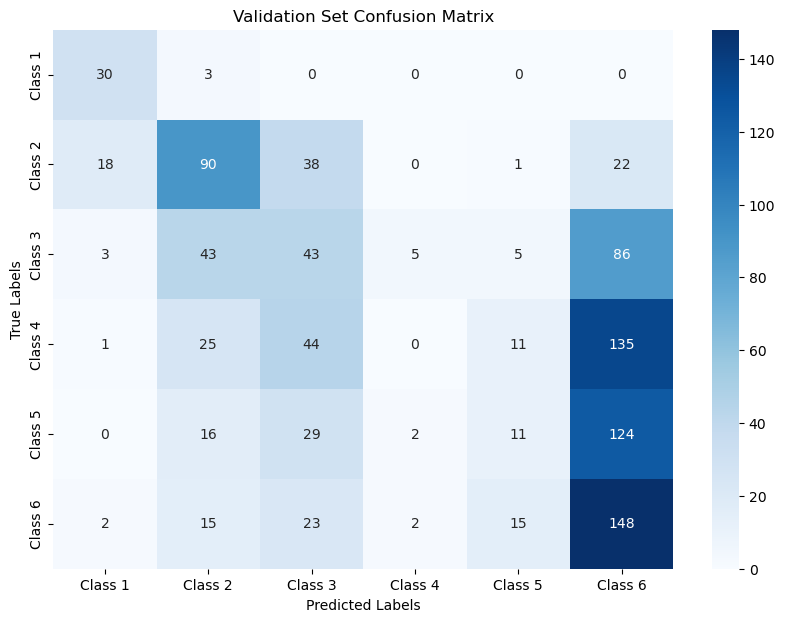

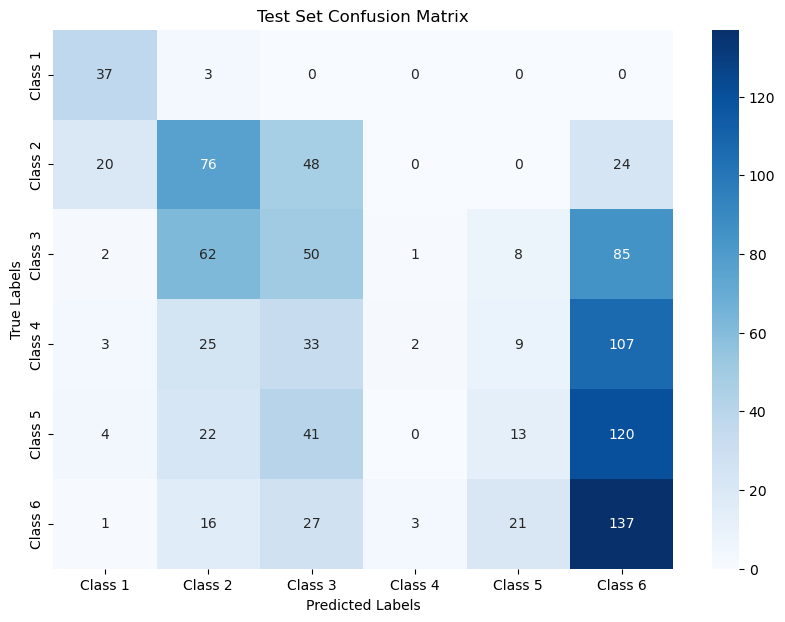

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix_val = np.array([[30, 3, 0, 0, 0, 0],
                            [18, 90, 38, 0, 1, 22],
                            [3, 43, 43, 5, 5, 86],
                            [1, 25, 44, 0, 11, 135],
                            [0, 16, 29, 2, 11, 124],
                            [2, 15, 23, 2, 15, 148]])

conf_matrix_test = np.array([[37, 3, 0, 0, 0, 0],
                             [20, 76, 48, 0, 0, 24],
                             [2, 62, 50, 1, 8, 85],
                             [3, 25, 33, 2, 9, 107],
                             [4, 22, 41, 0, 13, 120],
                             [1, 16, 27, 3, 21, 137]])

# Class labels (adjust as necessary based on the actual classes)
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']

# Plotting function
def plot_confusion_matrix(cm, title, class_labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plotting
plot_confusion_matrix(conf_matrix_val, "Validation Set Confusion Matrix", class_labels)
plot_confusion_matrix(conf_matrix_test, "Test Set Confusion Matrix", class_labels)


C:\Users\ravee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


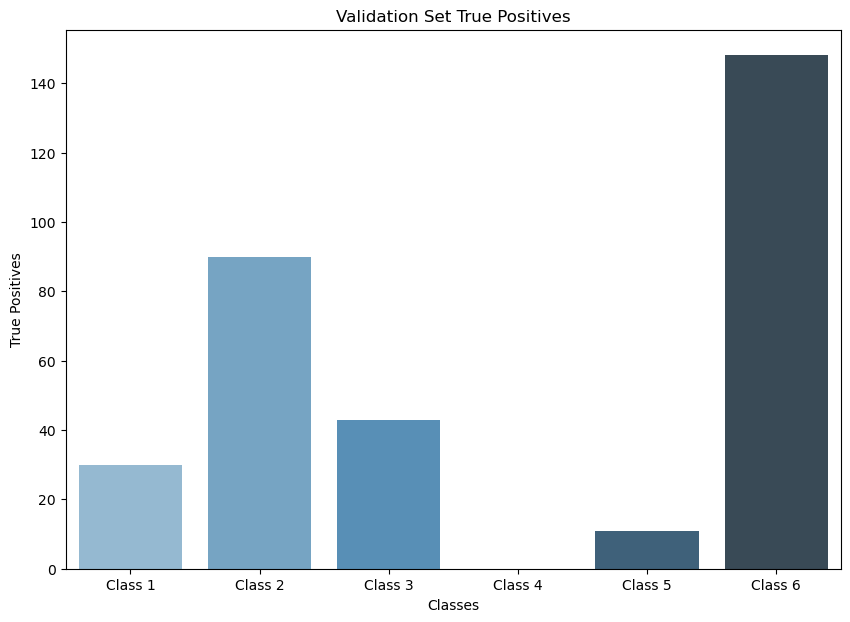

C:\Users\ravee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


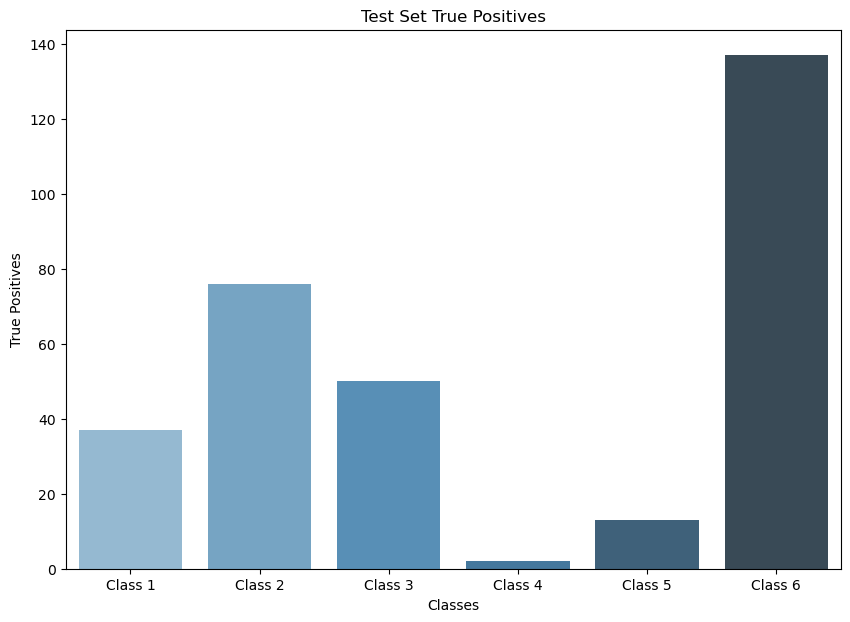

In [10]:
# Extracting true positives for each class
def get_true_positives(cm):
    return np.diag(cm)
# Extract true positives
true_positives_val = get_true_positives(conf_matrix_val)
true_positives_test = get_true_positives(conf_matrix_test)# Plotting function for bar plot
def plot_bar(true_positives, title, class_labels):
    plt.figure(figsize=(10, 7))
    sns.barplot(x=class_labels, y=true_positives, palette='Blues_d')
    plt.xlabel('Classes')
    plt.ylabel('True Positives')
    plt.title(title)
    plt.show()
# Plot bar plots
plot_bar(true_positives_val, "Validation Set True Positives", class_labels)
plot_bar(true_positives_test, "Test Set True Positives", class_labels)

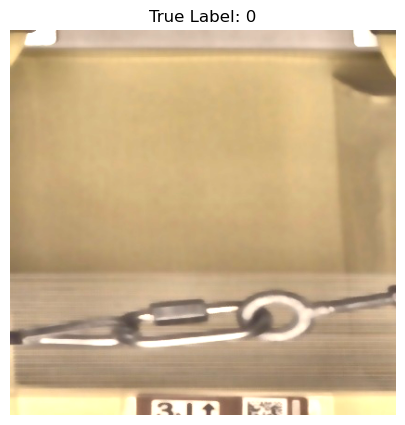

In [41]:
import os
from PIL import Image

# Function to display a single image from the dataset
def display_image(df, image_dir, index, transforms, brightness_factor=1.5):
    image_path = os.path.join(image_dir, df.iloc[index]['filename'])
    image = Image.open(image_path).convert('RGB')
    transformed_image = transforms(image)
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(brightness_factor)

    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(f"True Label: {df.iloc[index]['quantity']}")
    plt.axis('off')
    plt.show()

# Display an image from the test set
test_index = 16  # Change this index to view different images from the test set
display_image(test, image_dir, test_index, image_transforms)


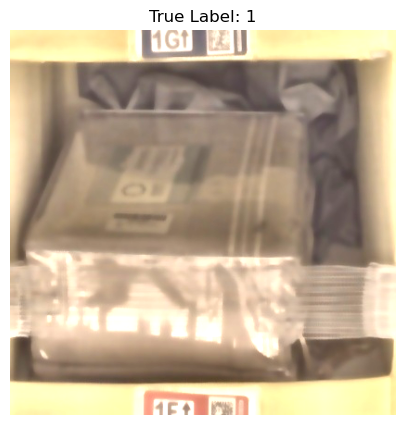

In [42]:
test_index = 20  # Change this index to view different images from the test set
display_image(test, image_dir, test_index, image_transforms)

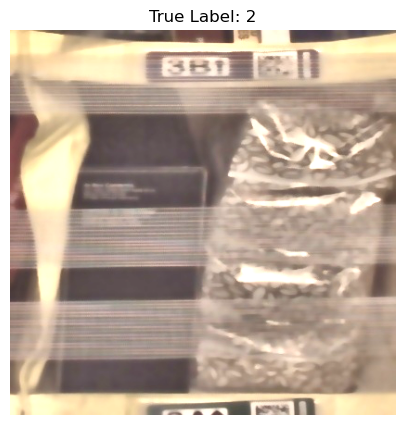

In [43]:
test_index = 45  # Change this index to view different images from the test set
display_image(test, image_dir, test_index, image_transforms)

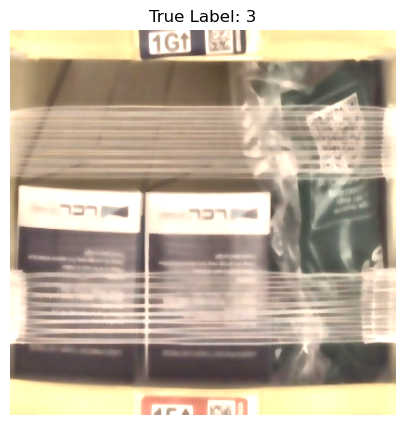

In [44]:
test_index = 2  # Change this index to view different images from the test set
display_image(test, image_dir, test_index, image_transforms)

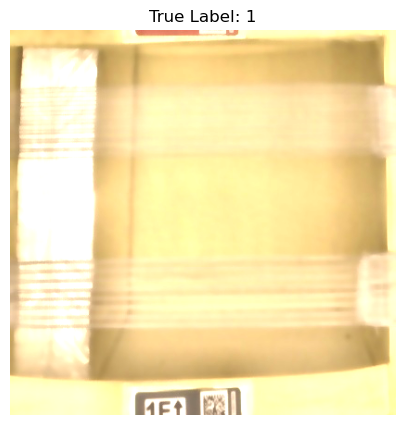

In [45]:
test_index = 8# Change this index to view different images from the test set
display_image(test, image_dir, test_index, image_transforms)

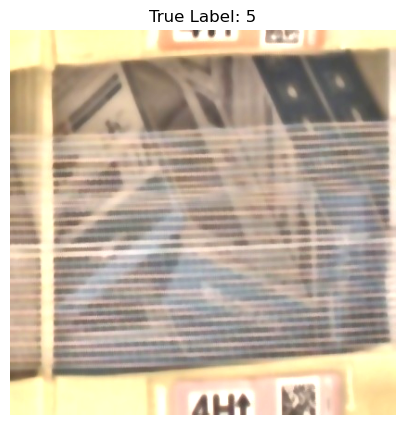

In [46]:
test_index = 1  # Change this index to view different images from the test set
display_image(test, image_dir, test_index, image_transforms)